# Setup

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

/var/folders/cn/qh1c0kgs1y7bqdlpqd82cpqc0000gn/T/ipykernel_79192/1099191483.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [69]:
procs_added = pd.read_csv("procs_added.txt", index_col=None, names=["tick", "machineID", "procType", "sla", "actualComp", "migrated"])
procs_current = pd.read_csv("procs_current.txt", index_col=None, names=["tick", "machineID", "sla", "actualComp", "compDone"])
procs_done = pd.read_csv("procs_done.txt", index_col=None, names=["tick", "machineID", "procType", "sla", "ticksPassed", "actualComp", "timesReplenished"])
procs_killed = pd.read_csv("procs_killed.txt", index_col=None, names=["tick", "machineID", "sla", "compDone", "memUsed"])

sched_decisions = pd.read_csv("sched.txt", index_col=None, names=["tick", "machineID", "sla", "compDone", "ticksPassed", "ticksGiven", "done"])


# Overview takeaways

In [70]:
# prepare
load_per_tick = procs_current[["tick"]].groupby("tick").size().reset_index(name='numProcsAdded')

procs_late = procs_done.where(procs_done["ticksPassed"] > procs_done["sla"]).dropna().reset_index(drop=True)
procs_late = procs_late.where(procs_late["ticksPassed"] > procs_late["actualComp"]).dropna().reset_index(drop=True)
procs_late['pctLate'] = (procs_late["ticksPassed"] - procs_late["sla"]) / procs_late["sla"]

final_late = pd.merge(procs_late, load_per_tick, on='tick', how='left')

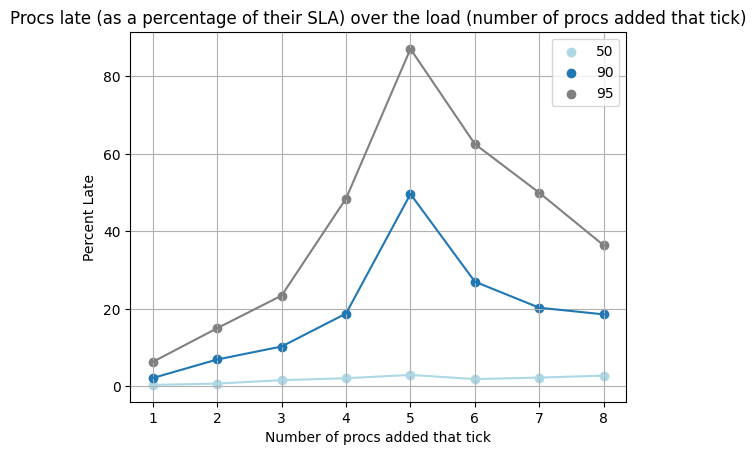

In [71]:
# Procs late (as a percentage of their SLA) over the load (number of procs currently live)
 
def get_percentile(pctile):
    return final_late[["numProcsAdded", "pctLate"]].groupby("numProcsAdded").quantile(pctile / 100).reset_index()

plt.scatter(get_percentile(50)["numProcsAdded"], get_percentile(50)["pctLate"], color='lightblue', label="50")
plt.plot(get_percentile(50)["numProcsAdded"], get_percentile(50)["pctLate"], color='lightblue')

plt.scatter(get_percentile(90)["numProcsAdded"], get_percentile(90)["pctLate"], label="90")
plt.plot(get_percentile(90)["numProcsAdded"], get_percentile(90)["pctLate"])

plt.scatter(get_percentile(95)["numProcsAdded"], get_percentile(95)["pctLate"], color='grey', label="95")
plt.plot(get_percentile(95)["numProcsAdded"], get_percentile(95)["pctLate"], color='grey')

plt.xlabel('Number of procs added that tick')
plt.ylabel('Percent Late')
plt.title('Procs late (as a percentage of their SLA) over the load (number of procs currently live)')
plt.grid(True)
plt.legend()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


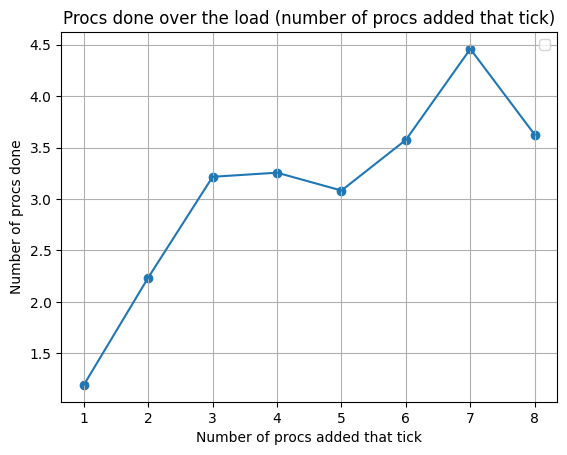

In [72]:
# Procs done over the load (number of procs currently live)
 
num_done = procs_done[["tick"]].groupby("tick").size().reset_index(name='numProcsDone')

merged_done_added = pd.merge(num_done, load_per_tick, on='tick', how='left')

avg_done = merged_done_added[["numProcsAdded", "numProcsDone"]].groupby("numProcsAdded").mean().reset_index()

plt.scatter(avg_done["numProcsAdded"], avg_done["numProcsDone"])
plt.plot(avg_done["numProcsAdded"], avg_done["numProcsDone"])

plt.xlabel('Number of procs added that tick')
plt.ylabel('Number of procs done')
plt.title('Procs done over the load (number of procs currently live)')
plt.grid(True)
plt.legend()
plt.show()

In [59]:
# procs late
avg_pct_late = procs_late['pctLate'].mean()
num_procs_late = procs_late.shape[0]
print("procs late: " + str(num_procs_late))
print("avg pct late: " + str(avg_pct_late))

# procs killed
num_procs_killed = procs_killed.shape[0]
print("procs killed: " + str(num_procs_killed))

procs late: 277
avg pct late: 7.96174931538281
procs killed: 0


# Procs late overview

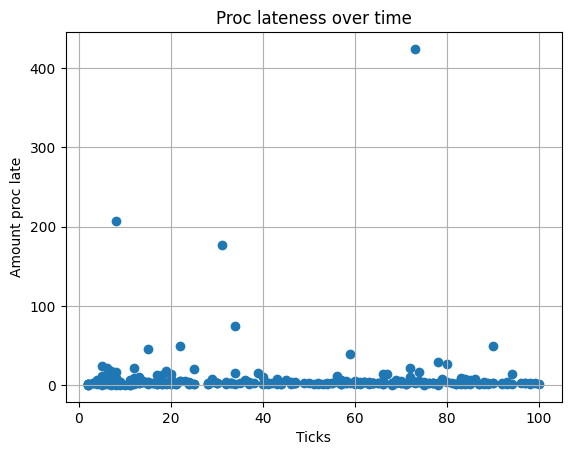

In [60]:
# plot by tick
plt.scatter(procs_late["tick"], procs_late['pctLate'].values)
plt.xlabel('Ticks')
plt.ylabel('Amount proc late')
plt.title('Proc lateness over time')
plt.grid(True)
plt.show()

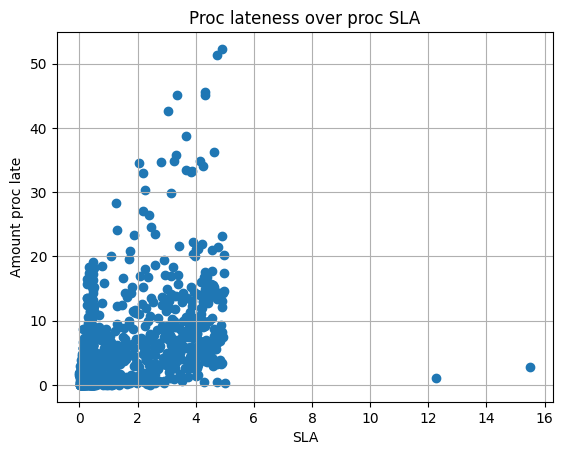

In [97]:
# plot by SLA
plt.scatter(procs_late["sla"], procs_late['amountLate'].values)
plt.xlabel('SLA')
plt.ylabel('Amount proc late')
plt.title('Proc lateness over proc SLA')
plt.grid(True)
plt.show()

# Procs killed overview

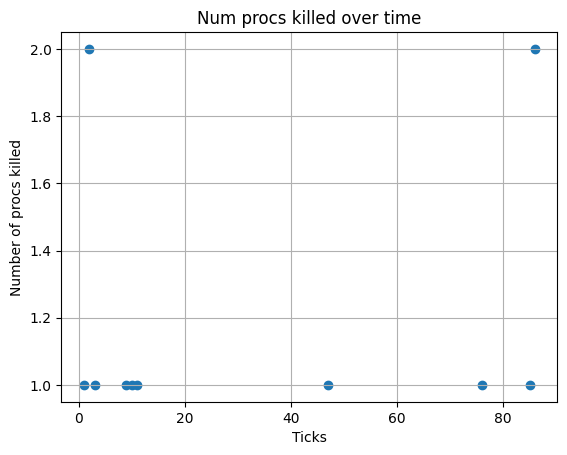

In [98]:
# plot by tick
ticks_procs_killed = procs_killed[["tick"]].groupby("tick").size().reset_index(name='counts')
ticks_procs_killed

plt.scatter(ticks_procs_killed["tick"], ticks_procs_killed['counts'].values)
plt.xlabel('Ticks')
plt.ylabel('Number of procs killed')
plt.title('Num procs killed over time')
plt.grid(True)
plt.show()

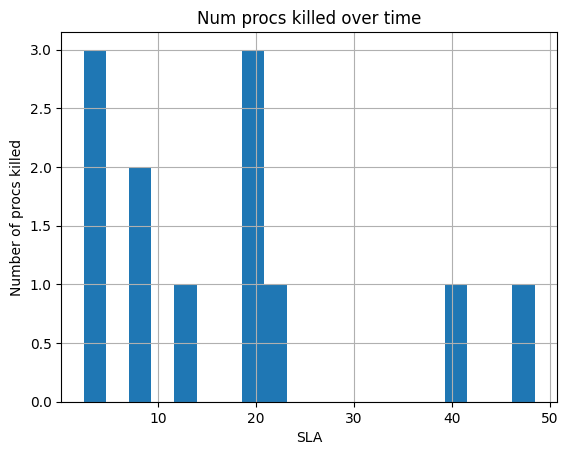

In [102]:
# plot by SLA
plt.hist(procs_killed["sla"], bins=20)
plt.xlabel('SLA')
plt.ylabel('Number of procs killed')
plt.title('Num procs killed over time')
plt.grid(True)
plt.show()

# Utilization Overview

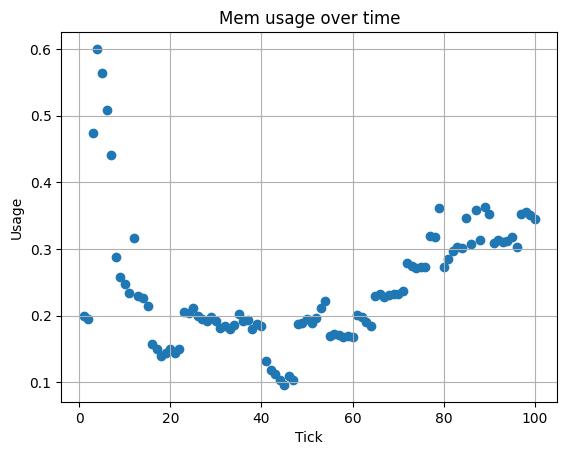

In [121]:
# plot memory usage over time
grouped = active_machines_usage.groupby('tick')["memUsage"].mean().reset_index()
# grouped["tick"]
plt.scatter(grouped["tick"], grouped["memUsage"])
plt.xlabel('Tick')
plt.ylabel('Memory Usage')
plt.title('Mem usage over time')
plt.grid(True)
plt.show()

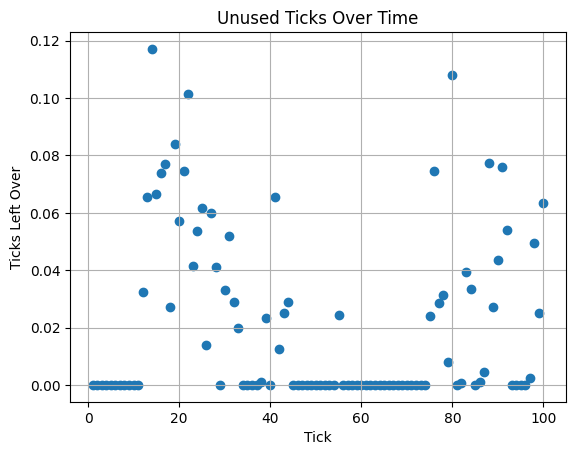

In [123]:
# plot ticks left over, over time
grouped = active_machines_usage.groupby('tick')["unusedTicks"].mean().reset_index()
# grouped["tick"]
plt.scatter(grouped["tick"], grouped["unusedTicks"])
plt.xlabel('Tick')
plt.ylabel('Ticks Left Over')
plt.title('Unused Ticks Over Time')
plt.grid(True)
plt.show()